In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import zipline
from zipline.api import (
    future_symbol,
    set_commission,
    set_slippage,
    schedule_function,
    date_rules,
    time_rules,
    continuous_future,
    order_target,
)
from datetime import datetime
import pyfolio as pf
import pandas as pd
import numpy as np

from zipline.finance.commission import PerTrade, PerContract
from zipline.finance.slippage import FixedSlippage, VolatilityVolumeShare

<IPython.core.display.Javascript object>

In [3]:
# These lines are for the dynamic text reporting
from IPython.display import display
import ipywidgets as widgets

out = widgets.HTML()
display(out)

HTML(value='')

<IPython.core.display.Javascript object>

In [4]:
"""
Model Settings
"""
starting_portfolio = 20000000
vola_window = 40
slow_ma = 80
fast_ma = 40
risk_factor = 0.0015
high_window = 20
days_to_hold = 20
dip_buy = -3

<IPython.core.display.Javascript object>

In [5]:
def report_result(context, data):
    context.months += 1
    today = zipline.api.get_datetime().date()
    # Calculate annualized return so far
    ann_ret = (
        np.power(
            context.portfolio.portfolio_value / starting_portfolio, 12 / context.months
        )
        - 1
    )

    # Update the text
    out.value = """{} We have traded <b>{}</b> months 
    and the annualized return is <b>{:.2%}</b>""".format(
        today, context.months, ann_ret
    )

<IPython.core.display.Javascript object>

In [6]:
def initialize(context):
    """
    Cost Settings
    """
    context.enable_commission = True
    context.enable_slippage = True

    if context.enable_commission:
        comm_model = PerContract(cost=0.85, exchange_fee=1.5)
    else:
        comm_model = PerTrade(cost=0.0)
    set_commission(us_futures=comm_model)

    if context.enable_slippage:
        slippage_model = VolatilityVolumeShare(volume_limit=0.3)
    else:
        slippage_model = FixedSlippage(spread=0.0)

    set_slippage(us_futures=slippage_model)

    #     agricultural = [
    #         "BL",
    #         "CC",
    #         "CT",
    #         "FC",
    #         "KC",
    #         "LB",
    #         "LR",
    #         "OJ",
    #         "RR",
    #         "_S",
    #         "SB",
    #         "LC",
    #         "LS",
    #     ]
    #     nonagricultural = [
    #         "CL",
    #         "GC",
    #         "HG",
    #         "HO",
    #         "LG",
    #         "PA",
    #         "PL",
    #         "RB",
    #         "SI",
    #         "NG",
    #         "LO",
    #     ]
    #     currencies = [
    #         "AD",
    #         "BP",
    #         "CD",
    #         "CU",
    #         "DX",
    #         "NE",
    #         "SF",
    #         "JY",
    #     ]
    #     equities = [
    #         "ES",
    #         "NK",
    #         "NQ",
    #         "YM",
    #     ]
    #     rates = [
    #         "ED",
    #         "FV",
    #         "TU",
    #         "TY",
    #         "US",
    #     ]

    #     markets = agricultural + nonagricultural + currencies + equities + rates
    # since we used random futures data...
    # see Chapter 16 for how to generate the random futures bundle
    markets = pd.read_csv("/tmp/random_test_data/data/futures_meta/meta.csv")[
        "root_symbol"
    ].tolist()

    #     not sure why but these markets have problems rolling over
    PROBLEMATIC_MARKETS = [
        "CL",
        "DA",
        "KW",
        "LO",
        "LG",
        "MP",
        "MW",
        "NG",
        "TF",
        "YM",
        "_W",
    ]
    markets = [market for market in markets if market not in PROBLEMATIC_MARKETS]

    context.universe = [
        continuous_future(market, offset=0, roll="volume", adjustment="mul")
        for market in markets
    ]

    # Dictionary used for keeping track of how many days a position has been open.
    context.bars_held = {market.root_symbol: 0 for market in context.universe}

    # Schedule daily trading
    schedule_function(daily_trade, date_rules.every_day(), time_rules.market_close())

    # We'll just use this for the progress output
    # during the backtest. Doesn't impact anything.
    context.months = 0

    # Schedule monthly report output
    schedule_function(
        func=report_result,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open(),
    )

<IPython.core.display.Javascript object>

In [7]:
def roll_futures(context, data):
    open_orders = zipline.api.get_open_orders()

    for held_contract in context.portfolio.positions:
        # don't roll positions that are set to change by core logic
        if held_contract in open_orders:
            continue

        # Save some time by only checking rolls for
        # contracts expiring in the next week
        days_to_auto_close = (
            held_contract.auto_close_date.date() - data.current_session.date()
        ).days
        if days_to_auto_close > 5:
            continue

        # Make a continuation
        continuation = continuous_future(
            held_contract.root_symbol, offset=0, roll="volume", adjustment="mul"
        )

        # Get the current contract of the continuation
        continuation_contract = data.current(continuation, "contract")

        if continuation_contract != held_contract:
            # Check how many contracts we hold
            pos_size = context.portfolio.positions[held_contract].amount
            # Close current position
            order_target(held_contract, 0)
            # Open new position
            order_target(continuation_contract, pos_size)

<IPython.core.display.Javascript object>

In [8]:
def position_size(portfolio_value, std, pv):
    target_variation = portfolio_value * risk_factor
    contract_variation = std * pv
    contracts = target_variation / contract_variation
    # Return rounded down number.
    return int(np.nan_to_num(contracts))

<IPython.core.display.Javascript object>

In [9]:
def daily_trade(context, data):

    open_pos = {pos.root_symbol: pos for pos in context.portfolio.positions}

    hist = data.history(
        context.universe,
        fields=["close", "volume"],
        frequency="1d",
        bar_count=250,
    )

    # Calculate the trend
    hist["trend"] = (
        hist["close"].ewm(span=fast_ma).mean() > hist["close"].ewm(span=slow_ma).mean()
    )

    for continuation in context.universe:
        root = continuation.root_symbol

        # Slice off history for this market
        h = hist.xs(continuation, 2)

        # Calculate volatility
        std = h.close.diff()[-vola_window:].std()

        if root in open_pos:  # Check open positions first.
            context.bars_held[root] += 1  # One more day held

            if context.bars_held[root] >= 20:
                # Held for a month, exit
                contract = open_pos[root]
                order_target(contract, 0)

            elif h["trend"].iloc[-1] == False:
                # Trend changed, exit.
                contract = open_pos[root]
                order_target(contract, 0)

        else:  # Check for new entries
            if h["trend"].iloc[-1]:

                # Calculate the pullback
                pullback = (
                    h["close"].values[-1] - np.max(h["close"].values[-high_window:])
                ) / std

                if pullback < dip_buy:
                    # Get the current contract
                    contract = data.current(continuation, "contract")

                    # Calculate size
                    contracts_to_trade = position_size(
                        context.portfolio.portfolio_value,
                        std,
                        contract.price_multiplier,
                    )
                    # Trade
                    order_target(contract, contracts_to_trade)

                    # Reset bar count to zero
                    context.bars_held[root] = 0

    # Check if we need to roll.
    if len(open_pos) > 0:
        roll_futures(context, data)

<IPython.core.display.Javascript object>

In [10]:
start = pd.Timestamp("2018-01-01 08:15:12", tz="utc")
end = pd.Timestamp("2018-12-31 08:15:12", tz="utc")

<IPython.core.display.Javascript object>

In [11]:
%%time
perf = zipline.run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    capital_base=starting_portfolio,
    data_frequency="daily",
    bundle="random_futures",
)

<string>:12: UserWarning: Overwriting bundle with name 'random_futures'
<string>:18: UserWarning: Overwriting bundle with name 'random_futures'
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


CPU times: user 6min 8s, sys: 14.3 s, total: 6min 22s
Wall time: 12min 38s


<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/site-packages/empyrical/stats.py:447: RuntimeWarning: invalid value encountered in double_scalars
  return ending_value ** (1 / num_years) - 1
/usr/local/lib/python3.6/site-packages/empyrical/stats.py:1494: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()


Start date,2018-01-02
End date,2018-12-31
Total months,11
,Backtest
Annual return,nan%
Cumulative returns,-942.2%
Annual volatility,592.5%
Sharpe ratio,0.32
Calmar ratio,NaN
Stability,NaN
Max drawdown,-946.4%


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,946.37,2018-01-02,2018-12-28,NaT,NaN
1,0.00,2018-01-02,2018-01-02,2018-01-02,1
2,0.00,2018-01-02,2018-01-02,2018-01-02,1
3,0.00,2018-01-02,2018-01-02,2018-01-02,1
4,0.00,2018-01-02,2018-01-02,2018-01-02,1


/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute 

/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute 

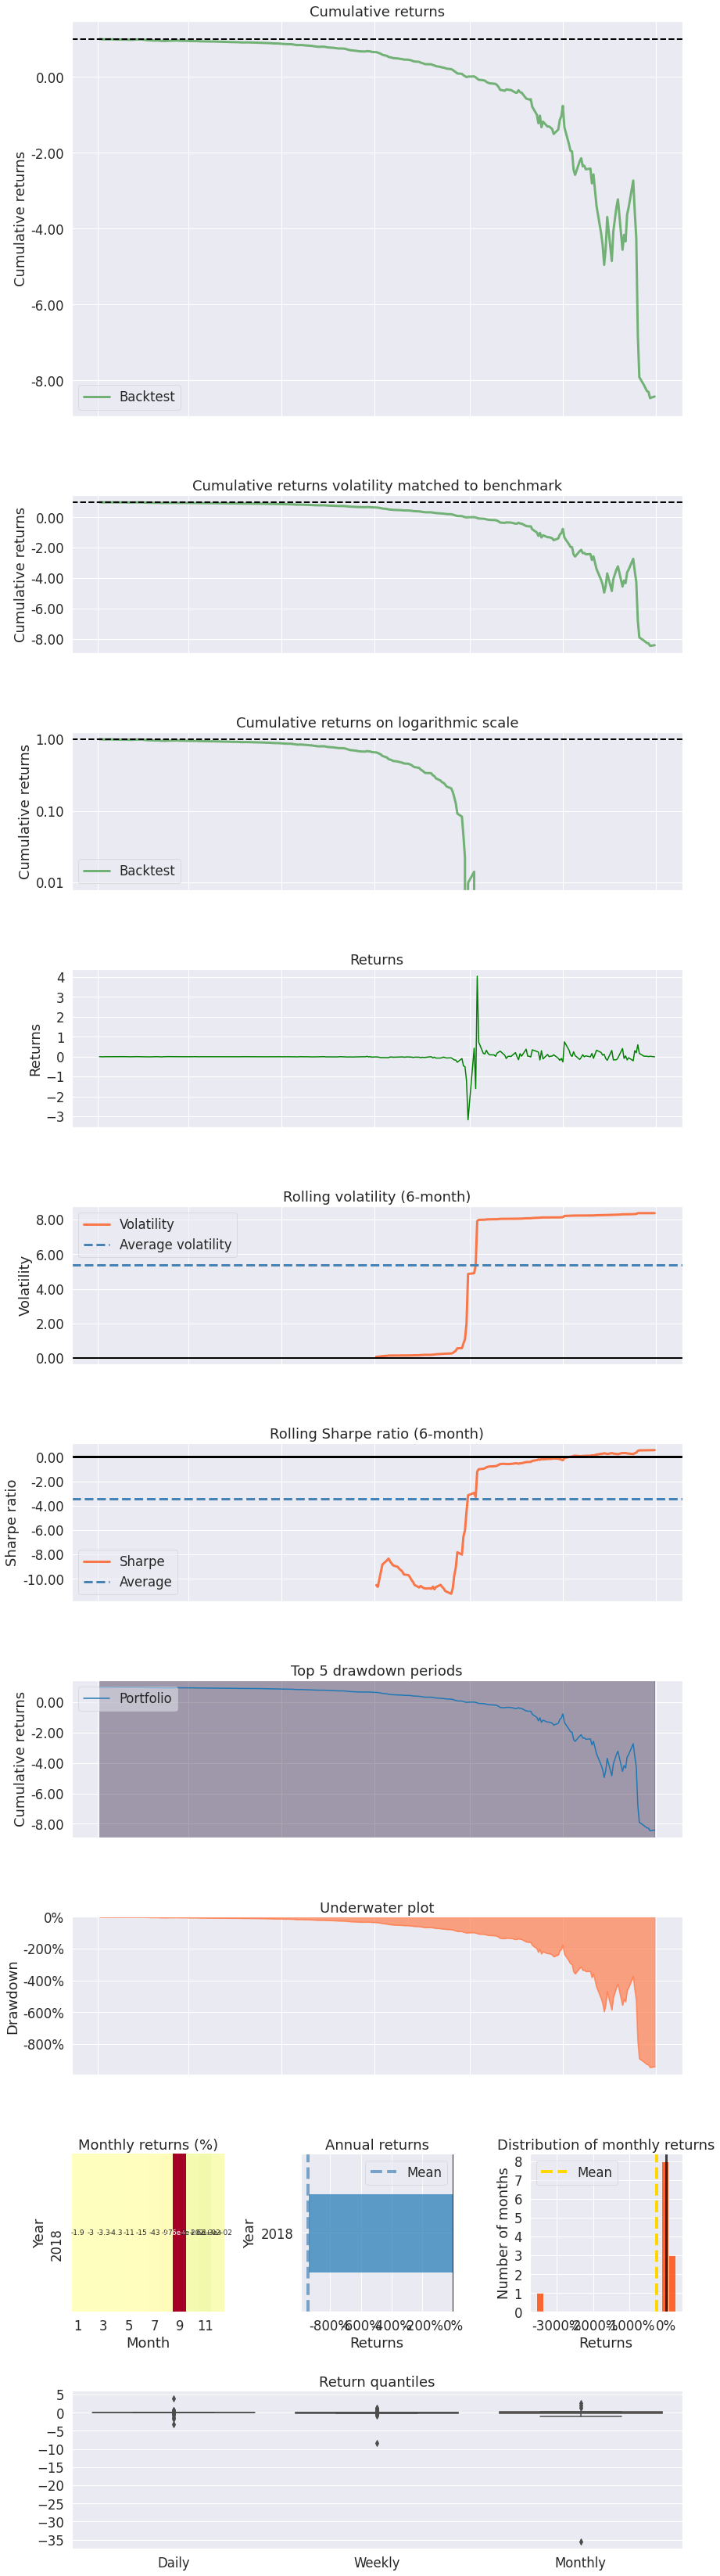

<IPython.core.display.Javascript object>

In [12]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
pf.create_returns_tear_sheet(returns, benchmark_rets=None)